Data Loaded Successfully.
Building Model...
Training Model... (This takes about 30 seconds)
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 0.0306
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0024
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0025
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0021
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0020
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0018
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0018
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0018
Epoch 9/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0019
Epoch 10/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0015
Epoch 11/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0019
Epoch 12/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0015
Epoch 13/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0014
Epoch 14/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0014
Epoch 15/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0015
Epoch 16/20
68/

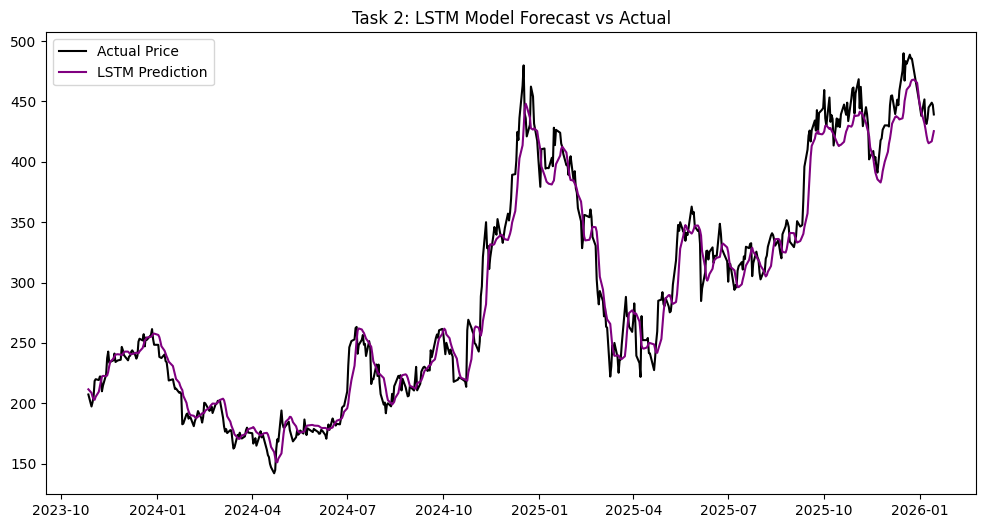


--- MODEL PERFORMANCE ---
LSTM MAE:  $12.68
LSTM RMSE: $16.99
LSTM MAPE: 4.35%


In [1]:
# --- GOOGLE COLAB LSTM SCRIPT ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Load Data
# Assuming you uploaded 'cleaned_close_prices.csv' to the Colab files area
try:
    df = pd.read_csv('cleaned_close_prices.csv', index_col=0, parse_dates=True)
    tsla = df['TSLA']
    print("Data Loaded Successfully.")
except FileNotFoundError:
    print("ERROR: Please upload 'cleaned_close_prices.csv' to the Files tab on the left!")

# 2. Data Split (80/20)
train_size = int(len(tsla) * 0.8)
train, test = tsla[:train_size], tsla[train_size:]

# 3. Create Sequences Function
def create_sequences(data, seq_length=60):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# 4. Prepare Data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit scaler ONLY on training data to avoid leakage
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))

seq_length = 60
X_train, y_train = create_sequences(train_scaled, seq_length)

# Reshape for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# 5. Build & Train Model
print("Building Model...")
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

print("Training Model... (This takes about 30 seconds)")
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# 6. Predict
print("Generating Predictions...")
# We need the last 60 days of train to predict the first day of test
dataset_total = pd.concat((train, test), axis=0)
inputs = dataset_total[len(dataset_total) - len(test) - seq_length:].values
inputs = inputs.reshape(-1,1)
inputs_scaled = scaler.transform(inputs)

X_test = []
for i in range(seq_length, len(inputs_scaled)):
    X_test.append(inputs_scaled[i-seq_length:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_prices_scaled = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices_scaled)

# 7. Visualize & Evaluate
lstm_preds = pd.Series(predicted_prices.flatten(), index=test.index)

plt.figure(figsize=(12,6))
plt.plot(test, label='Actual Price', color='black')
plt.plot(lstm_preds, label='LSTM Prediction', color='purple')
plt.title('Task 2: LSTM Model Forecast vs Actual')
plt.legend()
plt.show()

# Calculate Metrics
mae = mean_absolute_error(test, lstm_preds)
rmse = np.sqrt(mean_squared_error(test, lstm_preds))
mape = np.mean(np.abs((test - lstm_preds) / test)) * 100

print("\n--- MODEL PERFORMANCE ---")
print(f"LSTM MAE:  ${mae:.2f}")
print(f"LSTM RMSE: ${rmse:.2f}")
print(f"LSTM MAPE: {mape:.2f}%")